In [49]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# The setup

The purpose is to fit a *logistic* and an *exponential* function to the daily number of registered Hungarian Covid-19 cases.

These functions have the following forms:

Logistic $$f_{logit}(x) = \frac{a}{1 + e^{b (-x + c)}} + d$$

Exponential $$f_{exp}(x) = z * e^{v * x} + w$$

where $x$ is the number of days since he first registered patient, $a, b, c, z, v$ are parameters to estimate, $d$ and $w$ are initial number of patients. Given the number of cases was initially zero $d=w=0$.

In [533]:
def f_logit(x, a, b, c):
    return a / (1. + np.exp(b * (-x + c)))

def f_exp(x, z, v):
    return z * np.exp(v * x)

# Data

Because I did not find official sources I scraped the Hunarian wikipedia page:
https://hu.wikipedia.org/wiki/2020-as_COVID-19_koronav%C3%ADrus-j%C3%A1rv%C3%A1ny_Magyarorsz%C3%A1gon

In [65]:
import requests
import lxml.html as lh

url='https://hu.wikipedia.org/wiki/2020-as_COVID-19_koronav%C3%ADrus-j%C3%A1rv%C3%A1ny_Magyarorsz%C3%A1gon'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)

#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

Sanity check

In [66]:
#For sanity check see the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Processing the header

In [67]:
#At the time of the implementation the first 3 rows contain a disclaimer
table_starts_at = 3

#Create empty list
col=[]
i=0

#For each row, store each first element (header) and an empty list
for t in tr_elements[table_starts_at]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

Processing the body

In [68]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(table_starts_at+1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 6, the //tr data is not from our table 
    if len(T)!=6:
        print('Length of row {} is different from 6 cells'.format(j-table_starts_at))
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Sanity check

In [69]:
#Check the length of each column
[len(C) for (title,C) in col]

[18, 18, 18, 18, 18, 18]

Dataframe

In [110]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

# English header
df.columns = ['Date', 'Registered','Died','Recovered','Total','Note']


# Store the number of days since onset
df.reset_index(inplace=True)
df.set_index('Date',inplace=True)

df.rename(columns={ df.columns[0]: "Day" }, inplace = True)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text xticklabel objects>)

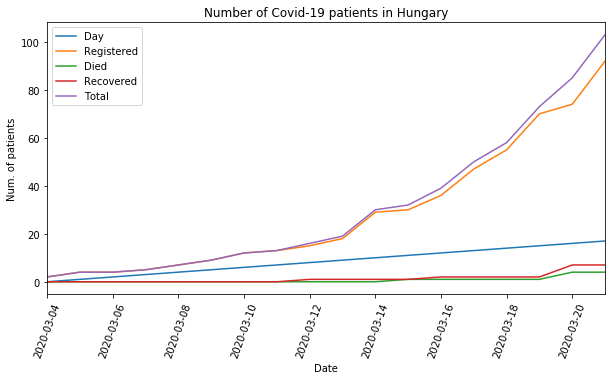

In [180]:
df.plot(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Num. of patients')
plt.title('Number of Covid-19 patients in Hungary')
degrees = 70
plt.xticks(rotation=degrees)

# Curve fitting

Exponential

In [559]:
parameters_exp, pcov_exp  = opt.curve_fit(f_exp, df['Day'].to_numpy()+1, df['Total'].to_numpy())
perr = np.sqrt(np.diag(pcov))

extrapol_horizon = 3
long_extrapol_horizon = 14

fitting_horizon = np.array(range(1,np.max(df['Day'].to_numpy()+2)+extrapol_horizon))
long_fitting_horizon = np.array(range(1,np.max(df['Day'].to_numpy()+2)+long_extrapol_horizon))

y_fit_exp = f_exp(fitting_horizon, *parameters_exp)
long_y_fit_exp = f_exp(long_fitting_horizon, *parameters_exp)

#Dates
times = pd.date_range('2020-03-04', periods=len(df['Day'])+extrapol_horizon, freq='D')
long_times = pd.date_range('2020-03-04', periods=len(df['Day'])+long_extrapol_horizon, freq='D')

Confidece intervals

In [560]:
# prepare confidence level curves
nstd = 1. # to draw 1-sigma intervals
parameters_exp_up = parameters_exp + nstd * perr
parameters_exp_dw = parameters_exp - nstd * perr

fit_up = f_exp(fitting_horizon, *parameters_exp_up)
fit_dw = f_exp(fitting_horizon, *parameters_exp_dw)

In [561]:
parameters_exp_dw

array([2.78841602, 0.19381005])

In [562]:
parameters_exp

array([2.9786906 , 0.19776742])

Sigmoid

In [563]:
parameters_logit = np.array([1200,0.5,12])
y_fit_logit = f_logit(fitting_horizon, *parameters_logit)
long_y_fit_logit = f_logit(long_fitting_horizon, *parameters_logit)

# Plots

[Text(0, 0, '03/04'),
 Text(0, 0, '03/05'),
 Text(0, 0, '03/06'),
 Text(0, 0, '03/07'),
 Text(0, 0, '03/08'),
 Text(0, 0, '03/09'),
 Text(0, 0, '03/10'),
 Text(0, 0, '03/11'),
 Text(0, 0, '03/12'),
 Text(0, 0, '03/13'),
 Text(0, 0, '03/14'),
 Text(0, 0, '03/15'),
 Text(0, 0, '03/16'),
 Text(0, 0, '03/17'),
 Text(0, 0, '03/18'),
 Text(0, 0, '03/19'),
 Text(0, 0, '03/20'),
 Text(0, 0, '03/21'),
 Text(0, 0, '03/22'),
 Text(0, 0, '03/23'),
 Text(0, 0, '03/24')]

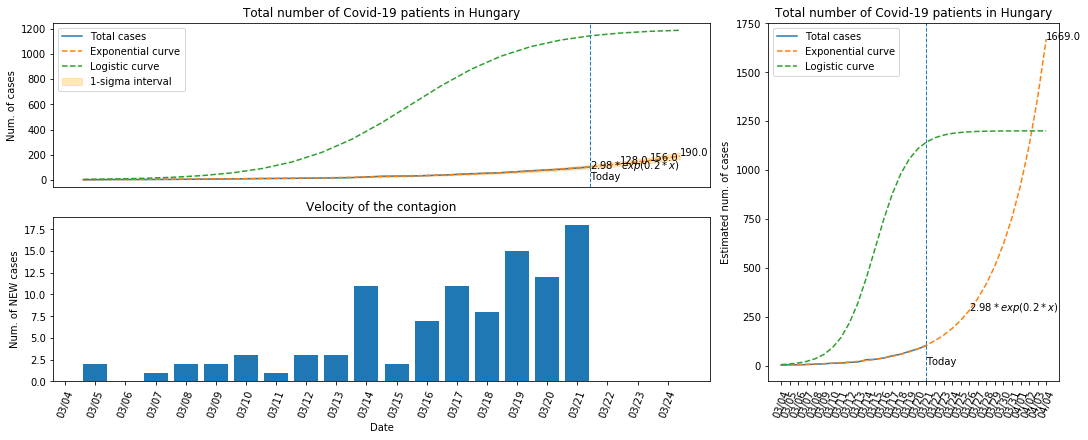

In [564]:
observed_dates = times[:len(df['Total'])].strftime("%m/%d")
all_dates = times.strftime("%m/%d")
long_all_dates = long_times.strftime("%m/%d")
degrees = 70

fig = plt.figure(figsize=(15, 6),constrained_layout=True)
gs = fig.add_gridspec(2, 9)

ax1= fig.add_subplot(gs[:, 5:9])
ax1.plot(observed_dates,df['Total'],label='Total cases')
ax1.plot(long_all_dates,long_y_fit_exp,'--',label='Exponential curve')
ax1.plot(long_all_dates,long_y_fit_logit,'--',label='Logistic curve')

ax1.set_xticklabels(long_all_dates,rotation=degrees)

ax1.legend(loc='best')

ax1.axvline(long_all_dates[-long_extrapol_horizon-1],linestyle='dashed',linewidth=1,label='Today')
ax1.annotate('Today',xy=(long_all_dates[-long_extrapol_horizon-1],5))
ax1.set(ylabel='Estimated num. of cases')
ax1.set(title='Total number of Covid-19 patients in Hungary')

for i,j in zip(long_all_dates[-1:],long_y_fit_exp[-1:]):
    ax1.annotate(str(round(j)),xy=(i,j))

ax1.annotate('${}*exp({}*x)$'.format(round(parameters_exp[0],2),round(parameters_exp[1],2)),xy=(long_all_dates[-10],long_y_fit_exp[-10]))

#ax1.set_yscale('log')


#--------------------

ax2 = fig.add_subplot(gs[0, 0:5])
ax2.plot(observed_dates,df['Total'],label='Total cases')
ax2.get_xaxis().set_ticks([])

ax2.set(ylabel='Num. of cases')
ax2.set(title='Total number of Covid-19 patients in Hungary')


ax2.plot(all_dates,y_fit_exp,'--',label='Exponential curve')
ax2.plot(all_dates,y_fit_logit,'--',label='Logistic curve')

for i,j in zip(all_dates[-extrapol_horizon:],y_fit_exp[-extrapol_horizon:]):
    ax2.annotate(str(round(j)),xy=(i,j))

ax2.fill_between(all_dates, fit_up, fit_dw, alpha=.25, label='1-sigma interval',color='orange')
#ax2.set_yscale('log')
ax2.legend(loc='best')

ax2.axvline(all_dates[-extrapol_horizon-1],linestyle='dashed',linewidth=1,label='Today')
ax2.annotate('Today',xy=(all_dates[-extrapol_horizon-1],5))

ax2.annotate('${}*exp({}*x)$'.format(round(parameters_exp[0],2),round(parameters_exp[1],2)),xy=(all_dates[-4],fit_dw[-4]))

#--------------------

ax3 = fig.add_subplot(gs[1, 0:5])
ax3.bar(all_dates,np.concatenate((df['Total'].diff(), np.full(len(all_dates)-len(observed_dates), 0)), axis=0))
ax3.set(xlabel='Date')
ax3.set(ylabel='Num. of NEW cases')
ax3.set(title='Velocity of the contagion')
ax3.set_xticklabels(all_dates,rotation=degrees)
